In [1]:
import torch
print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Version Used by PyTorch:", torch.version.cuda)


PyTorch Version: 2.5.1+cu121
CUDA Available: True
CUDA Version Used by PyTorch: 12.1


In [2]:
import torch

print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA Version Used by PyTorch:", torch.version.cuda)
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available. Check your setup.")


PyTorch Version: 2.5.1+cu121
CUDA Available: True
CUDA Version Used by PyTorch: 12.1
GPU Name: NVIDIA GeForce RTX 3060 Laptop GPU


In [3]:
import pickle
import os
import numpy as np
import pandas as pd
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.utils import resample
from torchvision import models
from sklearn.preprocessing import OneHotEncoder
from torch.amp import GradScaler, autocast
from torch.utils.data import Subset

from sklearn.utils import resample
import random

In [4]:
cpuCount = os.cpu_count()
print("Number of CPUs in the system:", cpuCount)

Number of CPUs in the system: 20


In [5]:
# Preprocessing for Dataset 1 (WM811K)
def preprocess_wm811k_data(path_to_dataset, target_size=(32, 32), num_classes =38, multi_label_ratio = 0.3):
    """
    Load and preprocess the WM811K dataset and generate synthetic multi-label data.

    Parameters:
        path_to_dataset (str): Path to the WM811K .pkl dataset.
        target_size (tuple): Desired image size.
        num_classes (int): Total number of classes.
        multi_label_ratio (float): Fraction of multi-label samples to generate.

    Returns:
        np.ndarray: Preprocessed wafer maps.
        np.ndarray: Multi-label one-hot encoded labels.
    """
    df = pd.read_pickle(path_to_dataset)
    df = df.drop(['waferIndex'], axis=1)
    df['waferMapDim'] = df['waferMap'].apply(lambda x: (np.size(x, axis=0), np.size(x, axis=1)))
    df['failureNum'] = df['failureType']

    mapping_type = {
        'Center': 0, 'Donut': 1, 'Edge-Loc': 2, 'Edge-Ring': 3,
        'Loc': 4, 'Random': 5, 'Scratch': 6, 'Near-full': 7, 'none': 8}
    df = df.replace({'failureNum': mapping_type})
    df_withpattern = df[(df['failureNum'] >= 0)].reset_index()

    wafer_maps = df_withpattern['waferMap'].to_numpy()
    labels = df_withpattern['failureNum'].to_numpy()

    processed_maps = []
    for wafer_map in wafer_maps:
        wafer_map = np.array(wafer_map, dtype=np.float32)
        wafer_map = (wafer_map - np.min(wafer_map)) / (np.max(wafer_map) - np.min(wafer_map))
        scaling_factor = min(target_size[1] / wafer_map.shape[1], target_size[0] / wafer_map.shape[0])
        new_width = int(wafer_map.shape[1] * scaling_factor)
        new_height = int(wafer_map.shape[0] * scaling_factor)
        resized_map = cv2.resize(wafer_map, (new_width, new_height), interpolation=cv2.INTER_AREA)
        padded_map = np.full(target_size, 0, dtype=np.float32)
        x_offset = (target_size[1] - new_width) // 2
        y_offset = (target_size[0] - new_height) // 2
        padded_map[y_offset:y_offset + new_height, x_offset:x_offset + new_width] = resized_map
        processed_maps.append(padded_map)

    # One-hot encode labels
    encoder = OneHotEncoder(sparse=False, categories='auto')
    labels = labels.reshape(-1, 1)  # Reshape for one-hot encoding
    one_hot_labels = encoder.fit_transform(labels)

    # Pad one-hot labels to 38 dimensions
    padded_labels = np.zeros((len(one_hot_labels), num_classes))
    padded_labels[:, :one_hot_labels.shape[1]] = one_hot_labels

    # Oversampling for balanced dataset
    combined = [(x, y) for x, y in zip(processed_maps, labels)]
    class_samples = {cls: [sample for sample in combined if sample[1] == cls] for cls in np.unique(labels)}
    max_class_size = max(len(samples) for samples in class_samples.values())
    oversampled_samples = []
    for cls, samples in class_samples.items():
        oversampled_samples.extend(resample(samples, replace=True, n_samples=max_class_size, random_state=42))
    np.random.shuffle(oversampled_samples)

    # Generate synthetic multi-label samples
    num_samples = len(oversampled_samples)
    num_multi_label_samples = int(multi_label_ratio * num_samples)

    multi_label_maps = []
    multi_label_labels = []

    for _ in range(num_multi_label_samples):
        # Randomly select two or more samples to combine
        indices = np.random.choice(len(oversampled_samples), size=2, replace=False)
        combined_map = np.maximum(oversampled_samples[indices[0]][0], oversampled_samples[indices[1]][0])
        combined_label = np.logical_or(oversampled_samples[indices[0]][1], oversampled_samples[indices[1]][1]).astype(np.float32)

        multi_label_maps.append(combined_map)
        multi_label_labels.append(combined_label)

    # Combine original and synthetic data
    all_maps = np.vstack([np.array([sample[0] for sample in oversampled_samples]), multi_label_maps])
    all_labels = np.vstack([np.array([sample[1] for sample in oversampled_samples]), multi_label_labels])

    return np.expand_dims(all_maps, axis=1), all_labels

In [6]:
# Preprocessing for Dataset 2 (MixedWM38)
def preprocess_npz_dataset(path, target_size=(32, 32), num_classes=38):
    """
    Preprocess the .npz dataset for mixed-type wafer maps.

    Parameters:
        path (str): Path to the .npz dataset.
        target_size (tuple): Desired image size.

    Returns:
        np.ndarray: Preprocessed wafer maps.
        np.ndarray: Multi-label one-hot encoded labels.
    """
    data = np.load(path)
    wafer_maps = data['arr_0']
    labels = data['arr_1']

    # Pad labels to match the model's expected number of classes
    padded_labels = np.zeros((labels.shape[0], num_classes))
    padded_labels[:, :labels.shape[1]] = labels

    processed_maps = []
    for wafer_map in wafer_maps:
        wafer_map = np.array(wafer_map, dtype=np.float32)
        wafer_map = (wafer_map - np.min(wafer_map)) / (np.max(wafer_map) - np.min(wafer_map))
        resized_map = cv2.resize(wafer_map, target_size, interpolation=cv2.INTER_AREA)
        processed_maps.append(resized_map)

    processed_maps = np.expand_dims(processed_maps, axis=1)
    return np.array(processed_maps), padded_labels

In [7]:
# Custom Dataset for PyTorch
class WaferDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = torch.tensor(self.data[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return image, label

In [8]:
class VGG16Classifier(nn.Module):
    def __init__(self, init_weights=True, num_classes=38, feature_dim=512):
        """
        VGG16-based Classifier for multi-label classification.

        Parameters:
            init_weights (bool): Whether to initialize weights.
            num_class (int): Number of output classes.
            feature_dim (int): Feature dimensionality from the feature extractor.
        """
        super(VGG16Classifier, self).__init__()
        self.classifier = nn.Sequential(
            #nn.Dropout(),
            nn.Linear(feature_dim, 4096),
            #nn.BatchNorm1d(4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            #nn.BatchNorm1d(4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten features for linear layers
        x = self.classifier(x)
        return torch.sigmoid(x)  # Sigmoid for multi-label classification

    def _initialize_weights(self):
        """
        Initializes the weights of the classifier layers.
        """
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)


In [9]:
class CDADA:
    def __init__(self, train_data, train_labels,test_data,test_labels,*, num_classes=38, max_epoch=100, batch_size=32, learning_rate=0.0001, subset_size=None):
        """
        Initializes the CDADA training and evaluation pipeline.

        Parameters:
            train_data (np.ndarray): Training data.
            train_labels (np.ndarray): Labels for the training data.
            test_data (np.ndarray): Testing data.
            test_labels (np.ndarray): Labels for the testing data.
            num_classes (int): Number of classes for multi-label classification.
            max_epoch (int): Maximum number of epochs.
            batch_size (int): Batch size for training and testing.
            learning_rate (float): Learning rate for optimizers.
        """
        # Create subset if subset_size is specified
        if subset_size is not None:
                    # Generate random shuffled indices for the dataset
            total_indices = np.arange(len(train_data))
            np.random.shuffle(total_indices)
            
            # Select the first subset_size indices
            subset_indices = total_indices[:subset_size]
            
            # Create the subset dataset using the shuffled indices
            subset_data = train_data[subset_indices]
            subset_labels = train_labels[subset_indices]
            self.train_loader = DataLoader(WaferDataset(subset_data, subset_labels), batch_size=batch_size, shuffle=True)
        else:
            # Use full dataset
            self.train_loader = DataLoader(WaferDataset(train_data, train_labels), batch_size=batch_size, shuffle=True)
        #self.train_loader = DataLoader(WaferDataset(train_data, train_labels), batch_size=batch_size, shuffle=True)
        self.test_loader = DataLoader(WaferDataset(test_data, test_labels), batch_size=batch_size, shuffle=False)
        #self.pkl_file_path = pkl_file_path
        #self.npz_file_path = npz_file_path
        self.num_classes = num_classes
        self.max_epoch = max_epoch
        self.batch_size = batch_size
        self.learning_rate = learning_rate

        

        # Initialize VGG16 model
        model = models.vgg16(pretrained=True)
        model.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)  # Modify for grayscale input
        self.feature_extractor = model.features.to('cuda')
        self.classifier = VGG16Classifier(num_classes=num_classes).to('cuda')
        self.optimizer = optim.Adam(self.classifier.parameters(), lr=learning_rate)
        self.criterion = nn.BCELoss()

        # Initialize classifiers
        #feature_dim = 512
    

    def reset_grad(self):
        self.opt_generator.zero_grad()
        self.opt_classifier.zero_grad()

    def train(self):
        """
        Trains the model on the source dataset.
        """
        self.feature_extractor.train()
        self.classifier.train()
       

        for ep in range(self.max_epoch):
            running_loss = 0
            for images, labels in self.train_loader:
                images, labels = images.to('cuda'), labels.to('cuda')
                self.optimizer.zero_grad()
                
                features = self.feature_extractor(images)
                outputs = self.classifier(features)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()
        
            print(f"Epoch {ep + 1}/{self.max_epoch}, Loss: {running_loss:.4f}")

            

    def test(self):
        """
        Tests the model on the MixedWM38 dataset.
        """
        self.feature_extractor.eval()
        self.classifier.eval()

        all_labels = []
        all_outputs = []

        total_samples = 0
        correct_predictions = 0

        with torch.no_grad():
            for images, labels in self.test_loader:
                images, labels = images.to('cuda'), labels.to('cuda')

        

                features = self.feature_extractor(images)
                outputs = self.classifier(features)
                all_labels.append(labels.cpu())
                all_outputs.append(outputs.cpu())
                # Accuracy calculation
                predicted = (outputs > 0.5).float()  # Apply threshold for multi-label classification
                correct_predictions += (predicted == labels).all(dim=1).sum().item()
                total_samples += labels.size(0)
        all_labels = torch.cat(all_labels)
        all_outputs = torch.cat(all_outputs)
        # Calculate accuracy
        accuracy = 100 * correct_predictions / total_samples
        precision = precision_score(all_labels, all_outputs.round(), average='samples')
        recall = recall_score(all_labels, all_outputs.round(), average='samples')
        f1 = f1_score(all_labels, all_outputs.round(), average='samples')
        print(f"Accuracy: {accuracy:.2f}%")
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")


In [ ]:

train_data, train_labels = preprocess_wm811k_data("C:/Users/Soumya Taneja/Desktop/Sideproject/WM811Kdata/LSWMD.pkl")
test_data, test_labels = preprocess_npz_dataset("C:/Users/Soumya Taneja/Desktop/Sideproject/WM811Kdata/Wafer_Map_Datasets.npz", target_size=(32, 32))
cdada = CDADA(train_data, train_labels, test_data, test_labels, num_classes=38, max_epoch=50, subset_size = 80000)
cdada.train()



In [ ]:
cdada.test()

c:\Users\Soumya Taneja\myAnaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Soumya Taneja\myAnaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 6.36%
Precision: 0.3341, Recall: 0.1822, F1-Score: 0.2252


c:\Users\Soumya Taneja\myAnaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

def visualize_dataset(data, labels, title="Dataset Visualization", classes=None, cmap='gray'):
    """
    Visualizes the class distribution and random samples from the dataset.

    Parameters:
        data (np.ndarray): Wafer map images.
        labels (np.ndarray): Corresponding labels (can be one-hot encoded).
        title (str): Title for the visualization.
        classes (list, optional): Class names corresponding to labels.
        cmap (str): Colormap for grayscale images.
    """
    # Convert one-hot labels to scalar indices if necessary
    if len(labels.shape) > 1:  # Check if labels are one-hot encoded
        labels = np.argmax(labels, axis=1)

    # Plot class distribution
    class_counts = Counter(labels)
    plt.figure(figsize=(10, 5))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.title(f"Class Distribution: {title}")
    plt.xlabel("Class")
    plt.ylabel("Count")
    if classes:
        plt.xticks(range(len(classes)), classes, rotation=45)
    else:
        plt.xticks(range(max(class_counts.keys()) + 1))
    plt.show()

    # Display random samples from the dataset
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    indices = np.random.choice(len(data), size=5, replace=False)
    for i, idx in enumerate(indices):
        axes[i].imshow(data[idx].squeeze(), cmap=cmap)
        axes[i].set_title(f"Class: {labels[idx]}")
        axes[i].axis('off')
    plt.suptitle(f"Random Samples: {title}")
    plt.show()


c:\Users\Soumya Taneja\myAnaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


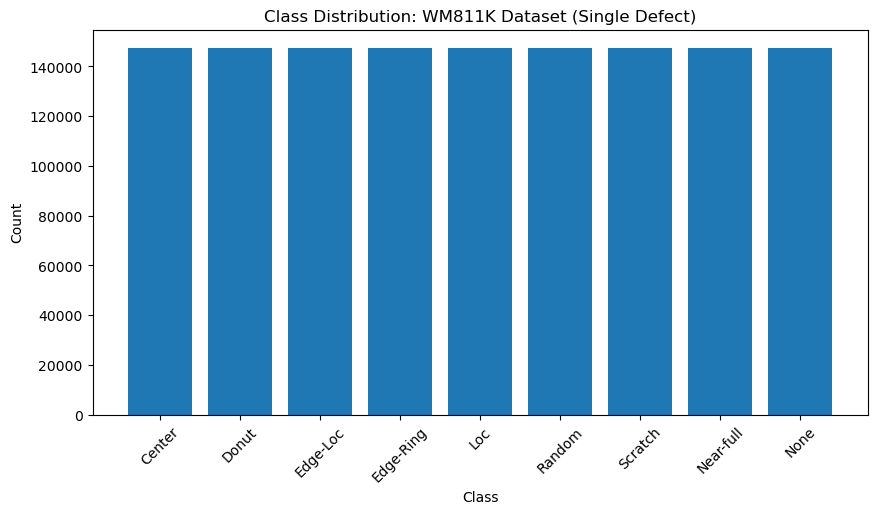

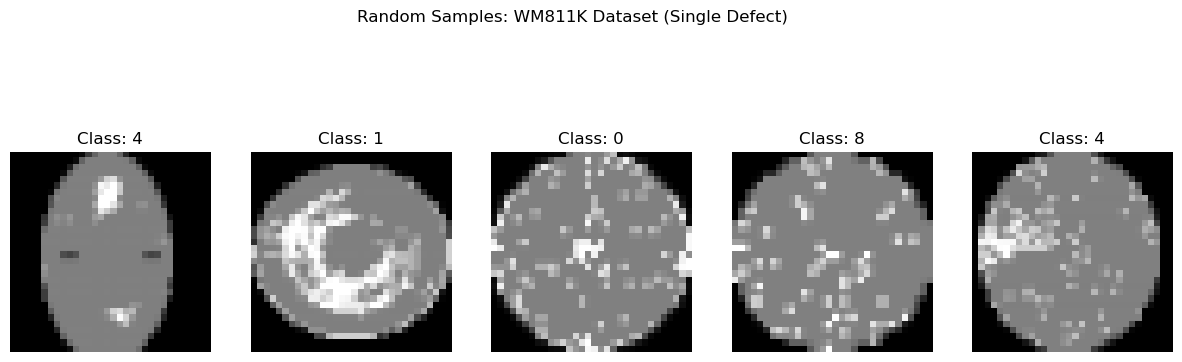

In [ ]:
# Load Dataset1 (WM811K)
wm811k_data, wm811k_labels = preprocess_wm811k_data("C:/Users/Soumya Taneja/Desktop/Sideproject/WM811Kdata/LSWMD.pkl")

# Class Names for WM811K
wm811k_classes = ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Random', 'Scratch', 'Near-full', 'None']

# Visualize WM811K Dataset
visualize_dataset(wm811k_data, wm811k_labels, title="WM811K Dataset (Single Defect)", classes=wm811k_classes)


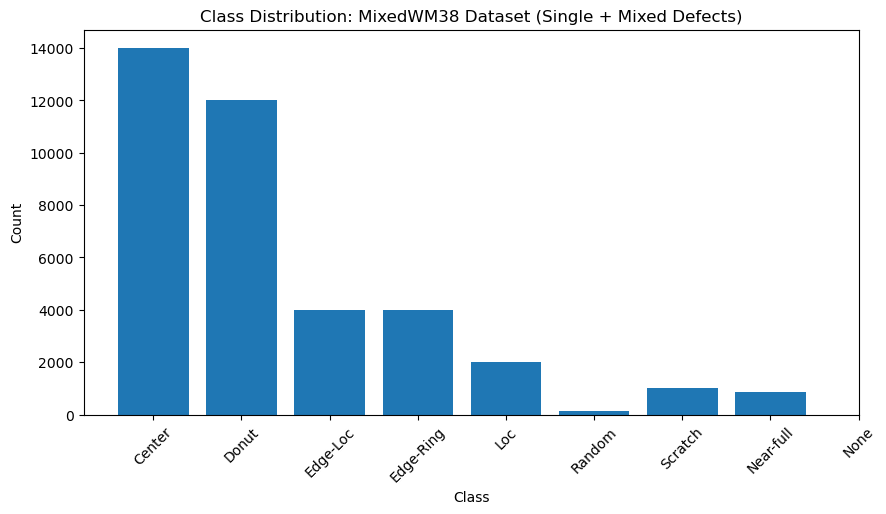

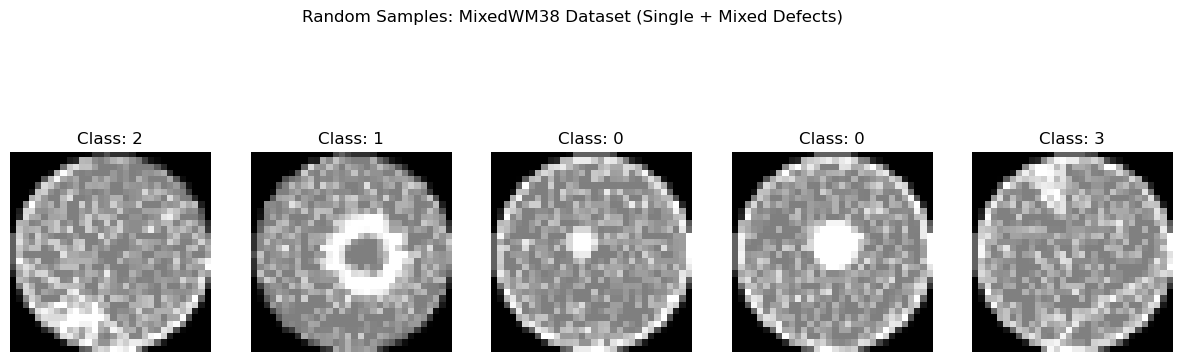

In [ ]:
# Load Dataset2 (MixedWM38)
mixed_data, mixed_labels = preprocess_npz_dataset("C:/Users/Soumya Taneja/Desktop/Sideproject/WM811Kdata/Wafer_Map_Datasets.npz")

# Class Names for MixedWM38
mixed_classes = ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Random', 'Scratch', 'Near-full','None']

# Visualize MixedWM38 Dataset
visualize_dataset(mixed_data, mixed_labels, title="MixedWM38 Dataset (Single + Mixed Defects)", classes=mixed_classes)


In [ ]:
def visualize_mixed_defects(data, labels, title="Mixed Defect Wafer Maps Visualization", classes=None, cmap='gray'):
    """
    Visualizes the class distribution and random samples for mixed defect wafer maps.

    Parameters:
        data (np.ndarray): Wafer map images.
        labels (np.ndarray): Corresponding labels (one-hot encoded).
        title (str): Title for the visualization.
        classes (list, optional): Class names corresponding to labels.
        cmap (str): Colormap for grayscale images.
    """
    # Identify mixed defect wafer maps (labels with more than one "1")
    mixed_indices = [i for i, label in enumerate(labels) if np.sum(label) > 1]
    mixed_data = data[mixed_indices]
    mixed_labels = labels[mixed_indices]

    # Convert one-hot labels to scalar indices for mixed defects
    scalar_labels = [tuple(np.where(label == 1)[0]) for label in mixed_labels]

    # Plot class distribution for mixed defects
    label_counts = Counter(scalar_labels)
    plt.figure(figsize=(10, 5))
    plt.bar([str(k) for k in label_counts.keys()], label_counts.values())
    plt.title(f"Class Distribution: {title}")
    plt.xlabel("Mixed Defect Combination")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

    # Display random samples of mixed defects
    fig, axes = plt.subplots(1, min(5, len(mixed_data)), figsize=(15, 5))
    indices = np.random.choice(len(mixed_data), size=min(5, len(mixed_data)), replace=False)
    for i, idx in enumerate(indices):
        axes[i].imshow(mixed_data[idx].squeeze(), cmap=cmap)
        axes[i].set_title(f"Defects: {scalar_labels[idx]}")
        axes[i].axis('off')
    plt.suptitle(f"Random Mixed Defect Samples: {title}")
    plt.show()


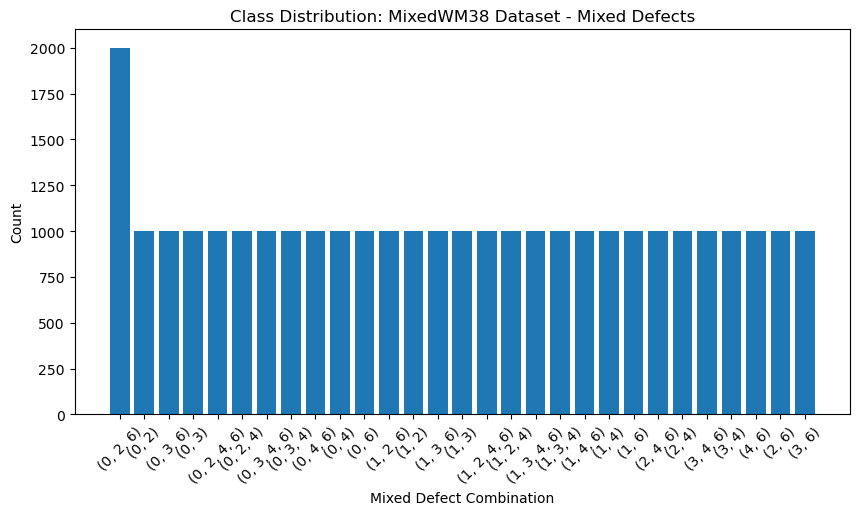

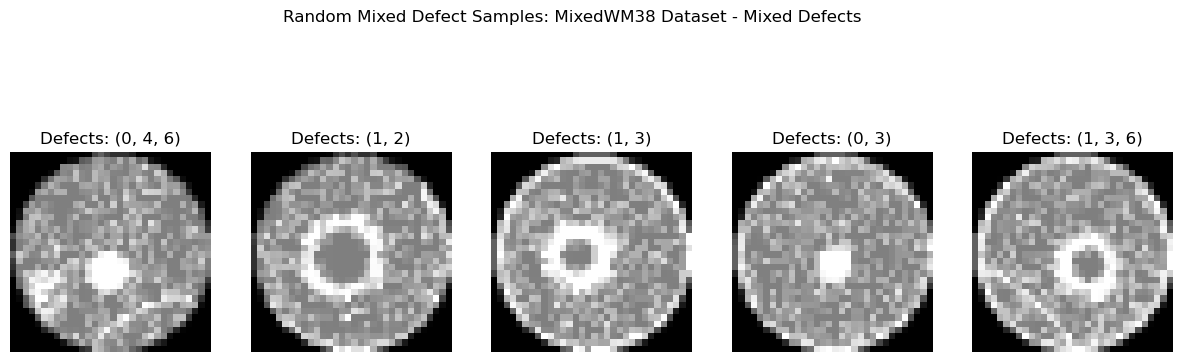

In [ ]:
# Load Dataset2 (MixedWM38)
mixed_data, mixed_labels = preprocess_npz_dataset("C:/Users/Soumya Taneja/Desktop/Sideproject/WM811Kdata/Wafer_Map_Datasets.npz")

# Class Names for MixedWM38
mixed_classes = ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Random', 'Scratch', 'Near-full', 'None']

# Visualize Mixed Defect Wafer Maps
visualize_mixed_defects(mixed_data, mixed_labels, title="MixedWM38 Dataset - Mixed Defects", classes=mixed_classes)
